In [1]:
from PIL import Image
from io import BytesIO
from IPython import display
import numpy as np

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

IMG_ROWS = 64
IMG_COLS = 64

data = np.load("../data/etl8.npz")['data']

In [2]:
import sklearn.model_selection
import keras
from scipy import ndimage

NUM_CLASSES = 956

# 150 ~ 159 for hyper parameters
alldata = data[0:150]
dataset_len = alldata.shape[0]

# flatten
x_all = alldata.reshape((dataset_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1))
x_all = x_all.astype(np.float32)
x_all /= 255
y_all = np.tile(np.arange(NUM_CLASSES), dataset_len)
y_all = keras.utils.to_categorical(y_all, NUM_CLASSES)

# # distortion (gaussian noise)
# hard_len = int(dataset_len / 10)
# soft_len = int(dataset_len / 2)
# keep_len = dataset_len - hard_len - soft_len
# hard_seed = 0.2 * np.random.randn(hard_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1)
# soft_seed = 0.05 * np.random.randn(soft_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1)
# keep_seed = np.zeros((keep_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1))
# seed = np.absolute(np.r_[hard_seed, soft_seed])
# seed = ndimage.gaussian_filter(seed, 1)
# seed = np.r_[seed, keep_seed]
# np.random.shuffle(seed)
# x_all += seed
# x_all /= (seed + 1)

# #  distortion (inverse)
# choice = np.random.rand(dataset_len * NUM_CLASSES)
# x_all[np.where(choice > 0.5)] *= -1
# x_all[np.where(choice > 0.5)] += 1

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_all, y_all, test_size=0.1)

Using TensorFlow backend.


In [3]:
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.preprocessing.image import ImageDataGenerator

input_shape = (IMG_ROWS, IMG_COLS, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(PReLU())
model.add(Dropout(0.25))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(PReLU())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 62, 62, 32)        123008    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 29, 29, 64)        53824     
__________

In [4]:
from keras.callbacks import Callback, EarlyStopping
datagen = ImageDataGenerator(
    rotation_range=12,
    zoom_range=[0.9, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="constant",
    cval=0.0
)
BATCH_SIZE = 128
steps = int(x_train.shape[0] / BATCH_SIZE)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=steps, epochs=2, verbose=True,
        validation_data=(x_test, y_test))

Epoch 1/2
1008/1008 [==============================] - 120s - loss: 5.5930 - acc: 0.0578 - val_loss: 3.7261 - val_acc: 0.2089
Epoch 2/2
1008/1008 [==============================] - 118s - loss: 2.2687 - acc: 0.4729 - val_loss: 1.2346 - val_acc: 0.6761


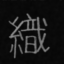

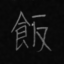

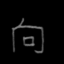

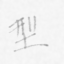

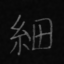

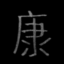

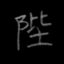

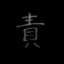

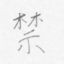

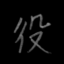

In [5]:
train_len = x_train.shape[0]

# distortion (gaussian noise)
hard_len = int(train_len / 10)
soft_len = int(train_len / 2)
keep_len = train_len - hard_len - soft_len
hard_seed = 0.2 * np.random.randn(hard_len, IMG_ROWS, IMG_COLS, 1)
soft_seed = 0.05 * np.random.randn(soft_len, IMG_ROWS, IMG_COLS, 1)
keep_seed = np.zeros((keep_len, IMG_ROWS, IMG_COLS, 1))
seed = np.absolute(np.r_[hard_seed, soft_seed])
seed = ndimage.gaussian_filter(seed, 1)
seed = np.r_[seed, keep_seed]
np.random.shuffle(seed)
x_train += seed
x_train /= (seed + 1)

#  distortion (inverse)
choice = np.random.rand(train_len)
x_train[np.where(choice > 0.5)] *= -1
x_train[np.where(choice > 0.5)] += 1

for i in range(10):
    display_image(x_train[i, :, :, 0] * 255)

In [6]:
BATCH_SIZE = 128
steps = int(x_train.shape[0] / BATCH_SIZE)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=steps, epochs=50, verbose=True,
        validation_data=(x_test, y_test))

Epoch 1/50
1008/1008 [==============================] - 118s - loss: 2.3413 - acc: 0.4795 - val_loss: 0.3342 - val_acc: 0.9356
Epoch 2/50
1008/1008 [==============================] - 118s - loss: 1.1052 - acc: 0.7154 - val_loss: 0.1943 - val_acc: 0.9613
Epoch 3/50
1008/1008 [==============================] - 118s - loss: 0.8139 - acc: 0.7859 - val_loss: 0.1714 - val_acc: 0.9636
Epoch 4/50
1008/1008 [==============================] - 118s - loss: 0.6479 - acc: 0.8268 - val_loss: 0.1502 - val_acc: 0.9625
Epoch 5/50
1008/1008 [==============================] - 118s - loss: 0.5441 - acc: 0.8535 - val_loss: 0.0932 - val_acc: 0.9781
Epoch 6/50
1008/1008 [==============================] - 118s - loss: 0.4752 - acc: 0.8725 - val_loss: 0.0945 - val_acc: 0.9759
Epoch 7/50
1008/1008 [==============================] - 118s - loss: 0.4277 - acc: 0.8844 - val_loss: 0.0959 - val_acc: 0.9738
Epoch 8/50
1008/1008 [==============================] - 118s - loss: 0.3934 - acc: 0.8931 - val_loss: 0.0778 - 

In [7]:
model.save("../etl8_noise_smoose.h5")

In [8]:
evaldata = data[150:]
dataset_len = evaldata.shape[0]

# flatten
x_eval = evaldata.reshape((dataset_len * NUM_CLASSES, IMG_ROWS, IMG_COLS, 1))
x_eval = x_eval.astype(np.float32)
x_eval /= 255
y_eval = np.tile(np.arange(NUM_CLASSES), dataset_len)
y_eval = keras.utils.to_categorical(y_eval, NUM_CLASSES)

model.evaluate(x_eval, y_eval)

9504/9560 [============================>.] - ETA: 0s

[0.021832448980774903, 0.99529288702928875]

In [9]:
score = model.predict(x_eval)
# predicted = np.array([np.argmax(r) for r in score])
predicted = np.argmax(score, axis=1)

idx, val = np.where(y_eval == 1)
ans = val[idx]

correct = np.where(predicted == ans)[0]
errors = np.where(predicted != ans)[0]

45
9515


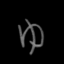

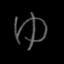

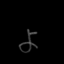

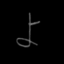

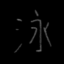

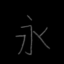

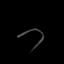

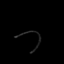

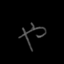

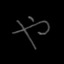

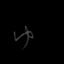

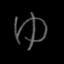

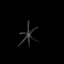

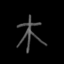

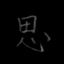

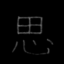

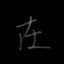

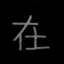

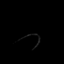

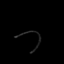

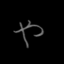

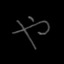

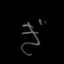

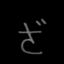

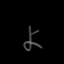

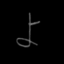

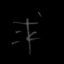

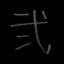

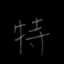

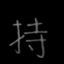

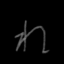

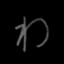

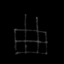

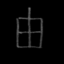

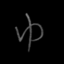

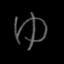

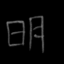

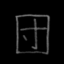

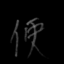

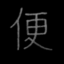

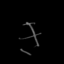

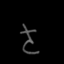

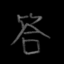

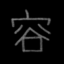

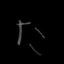

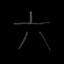

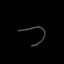

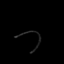

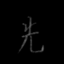

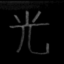

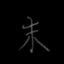

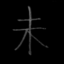

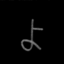

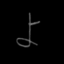

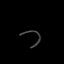

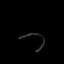

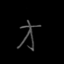

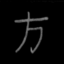

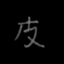

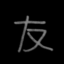

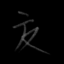

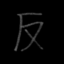

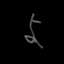

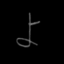

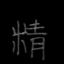

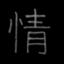

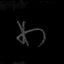

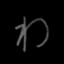

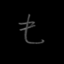

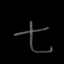

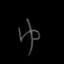

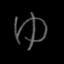

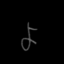

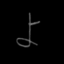

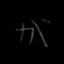

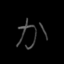

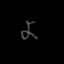

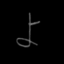

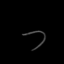

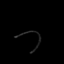

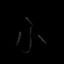

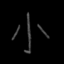

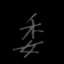

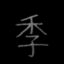

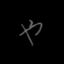

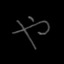

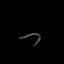

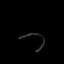

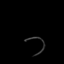

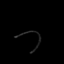

In [11]:
print(len(errors))
print(len(correct))
for e in errors:
    display_image((x_eval[e] * 255).reshape(IMG_ROWS, IMG_COLS))
    display_image(data[0][predicted[e]])